In [ ]:
Імпортуємо необхідні бібліотеки

In [38]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
import random
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

In [39]:
import warnings
# Вимкнути всі попередження для видаленн зайвої інформації з консолі
warnings.filterwarnings('ignore')

In [64]:
def prepare_data_with_colored_mask1(image, mask, color_to_class, pixel_sample_percentage):
    """
    Extract pixel coordinates and labels from the mask.
    
    Parameters:
        image: Input RGB image (not directly used here but kept for consistency in interfaces).
        mask: Input color mask indicating class labels.
        color_to_class: Dictionary mapping mask colors to class indices.
        pixel_sample_percentage: Percentage of pixels to select for training.
    
    Returns:
        sampled_coordinates: List of sampled pixel coordinates [(y, x)].
        sampled_labels: Corresponding class labels for the sampled pixels.
    """
    coordinates = []
    labels = []
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            b, g, r = mask[y, x]  # OpenCV uses BGR format
            color = (r, g, b)
            if color in color_to_class:
                coordinates.append((y, x))
                labels.append(color_to_class[color])
            elif color == (255, 255, 255):  # White pixels are ignored
                continue

    # Shuffle and sample pixels
    combined = list(zip(coordinates, labels))
    random.shuffle(combined)
    coordinates, labels = zip(*combined)
    
    # Select a subset based on pixel_sample_percentage
    sample_size = int(len(coordinates) * pixel_sample_percentage)
    sampled_coordinates = coordinates[:sample_size]
    sampled_labels = labels[:sample_size]
    
    return sampled_coordinates, sampled_labels

In [66]:
def prepare_data_with_colored_mask(image, mask, color_to_class, pixel_sample_percentage):
    """
    Вибирає координати та мітки із кольорової маски для тренування та генерує маску тренувальних пікселів.
    
    Parameters:
        image: Вхідне RGB-зображення.
        mask: Вхідна кольорова маска (BGR), яка вказує на мітки класів.
        color_to_class: Словник, що зв'язує кольори маски з індексами класів.
        pixel_sample_percentage: Відсоток пікселів для вибору в тренувальну підвибірку.
    
    Returns:
        sampled_coordinates: Список координат [(y, x)] вибраних пікселів.
        sampled_labels: Список міток класів для вибраних пікселів.
        temp_training_mask: Проміжна маска, що містить лише використовувані у тренуванні пікселі.
    """
    coordinates = []
    labels = []
    
    # Ініціалізуємо порожню маску для візуалізації тренувальних пікселів
    training_mask = np.ones_like(mask) * 255  # Маска спочатку біла (не використані пікселі)
    
    # Проходимо через пікселі вхідної маски
    for y in range(mask.shape[0]):
        for x in range(mask.shape[1]):
            b, g, r = mask[y, x]  # OpenCV використовує формат BGR
            color = (r, g, b)
            if color in color_to_class:
                coordinates.append((y, x))
                labels.append(color_to_class[color])
                # Копіюємо кольори з оригінальної маски в проміжну маску
                training_mask[y, x] = mask[y, x]
            elif color == (255, 255, 255):  # Ігноруємо білі пікселі
                continue

    # Перемішуємо та відбираємо пікселі
    combined = list(zip(coordinates, labels))
    random.shuffle(combined)
    coordinates, labels = zip(*combined)
    
    # Вибираємо підмножину пікселів для тренування
    sample_size = int(len(coordinates) * pixel_sample_percentage)
    sampled_coordinates = coordinates[:sample_size]
    sampled_labels = labels[:sample_size]
    
    # Змінюємо training_mask так, щоб залишилася тільки підвибірка
    temp_training_mask = np.ones_like(mask) * 255  # Створюємо нову маску з білим фоном
    for (y, x) in sampled_coordinates:
        temp_training_mask[y, x] = mask[y, x]  # Копіюємо тільки координати вибірки
    
    # Повертаємо результати
    return sampled_coordinates, sampled_labels, temp_training_mask

In [67]:
def extract_pixel_features_rgb_with_lbp_and_colors(image, coordinates, radius=1, n_points=8, method='uniform'):
    """
    Extract LBP features and RGB values for each pixel coordinate.
    
    Parameters:
        image: RGB input image.
        coordinates: List of pixel coordinates [(y1, x1), (y2, x2), ...].
        radius: Radius for the LBP descriptor.
        n_points: Number of sampling points for the LBP descriptor.
        method: LBP calculation method ('uniform', 'default', etc.).
    
    Returns:
        np.array: Feature vectors for each pixel.
    """
    features = []
    b_channel, g_channel, r_channel = cv2.split(image)

    for coord in coordinates:
        y, x = coord
        lbp_features = []
        for channel in [b_channel, g_channel, r_channel]:
            patch = channel[max(0, y - radius):min(channel.shape[0], y + radius + 1),
                            max(0, x - radius):min(channel.shape[1], x + radius + 1)]
            if patch.shape[0] < 2 * radius + 1 or patch.shape[1] < 2 * radius + 1:
                patch = cv2.resize(patch, (2 * radius + 1, 2 * radius + 1))
            lbp = local_binary_pattern(patch, P=n_points, R=radius, method=method)
            lbp_features.extend(lbp.flatten())

        rgb_values = [r_channel[y, x], g_channel[y, x], b_channel[y, x]]
        feature_vector = np.concatenate((lbp_features, rgb_values))
        features.append(feature_vector)

    return np.array(features)

In [90]:
def train_xgboost_classifier(features, labels):
    """
    Train an XGBoost classifier.
    
    Parameters:
        features: Feature matrix (N x M, where M is the feature size).
        labels: Corresponding labels (N x 1).
    
    Returns:
        Trained XGBoost model.
    """
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.99, random_state=42)

    model = xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=4,
        n_estimators=300,
        max_depth=6,
        eta=0.3
    )
    model.fit(X_train, y_train)
    
    # Evaluate model performance
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return model

In [91]:
def classify_entire_image(image, model, radius=1, n_points=8, class_to_color=None, expected_size=None):
    """
    Classify each pixel in the input image using the trained XGBoost model.
    
    Parameters:
        image: Input RGB image.
        model: Trained XGBoost model.
        radius: Radius for the LBP descriptor.
        n_points: Number of sampling points for the LBP descriptor.
        class_to_color: Mapping of class indices to RGB colors.
        expected_size: Expected size of feature vectors for inference (must match training).
    
    Returns:
        full_mask: Output classification mask (RGB image).
    """
    height, width = image.shape[:2]
    full_mask = np.zeros((height, width, 3), dtype=np.uint8)

    # Loop through each pixel and classify
    for y in range(height):
        for x in range(width):
            lbp_features = []
            for channel in cv2.split(image):
                patch = channel[max(0, y - radius):min(channel.shape[0], y + radius + 1),
                                max(0, x - radius):min(channel.shape[1], x + radius + 1)]
                if patch.shape[0] < 2 * radius + 1 or patch.shape[1] < 2 * radius + 1:
                    patch = cv2.resize(patch, (2 * radius + 1, 2 * radius + 1))
                lbp = local_binary_pattern(patch, P=n_points, R=radius, method='uniform')
                lbp_features.extend(lbp.flatten())

            rgb_values = [image[y, x, 2], image[y, x, 1], image[y, x, 0]]  # RGB order
            feature_vector = np.concatenate((lbp_features, rgb_values))

            # Ensure feature vector size matches training
            if expected_size is None:
                # Retrieve the feature size from the model (trained feature size)
                expected_size = len(model.feature_names_in_)  # Correct method

            if feature_vector.shape[0] != expected_size:
                feature_vector = np.pad(feature_vector, (0, expected_size - feature_vector.shape[0]), mode='constant')

            prediction = model.predict(np.array([feature_vector]))[0]
            full_mask[y, x] = class_to_color[prediction]

    return full_mask

In [92]:
# if __name__ == "__main__":
#     # Paths to images
#     image_path = "Images/sentinel/SS3/SS3.bmp"
#     mask_path = "Images/sentinel/SS3/EtalonS3.bmp"

#     # Read image and mask
#     rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    
#     # Mapping colors to class indices
#     color_to_class = {
#         (0, 0, 255): 0,    # Blue - Water
#         (0, 255, 0): 1,    # Green - Vegetation
#         (0, 0, 0): 2,      # Black - Bare soil
#         (255, 255, 0): 3   # Yellow - Urban
#     }

#     class_to_color = {v: k for k, v in color_to_class.items()}  # Reverse mapping for output

#     # Data preparation (now returns training mask)
#     sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
#         rgb_image, mask, color_to_class, pixel_sample_percentage=1.0
#     )

#     # Visualize selected training mask
#     cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Save training mask to file
#     plt.figure(figsize=(8, 8))
#     training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)
#     plt.imshow(training_mask_rgb)
#     plt.axis('off')
#     plt.title("Training Mask")
#     plt.show()

#     # Feature extraction
#     features = extract_pixel_features_rgb_with_lbp_and_colors(
#         rgb_image, sampled_coordinates, radius=2, n_points=16
#     )

#     # Train model
#     model = train_xgboost_classifier(features, sampled_labels)

#     # Retrieve feature size from training data for classification
#     expected_size = features.shape[1]  # Use the trained feature size

#     # Classify entire image
#     resulting_mask = classify_entire_image(
#         rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=expected_size
#     )
#      # Convert from BGR to RGB before saving and displaying
#     #resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)

#     # Save and display result
#     cv2.imwrite("Images/temp/result_colored_mask_lbp.png", resulting_mask_rgb)
#     plt.figure(figsize=(8, 8))
#     plt.imshow(resulting_mask)
#     plt.axis('off')
#     plt.title("Resulting Mask with LBP")
#     plt.show()

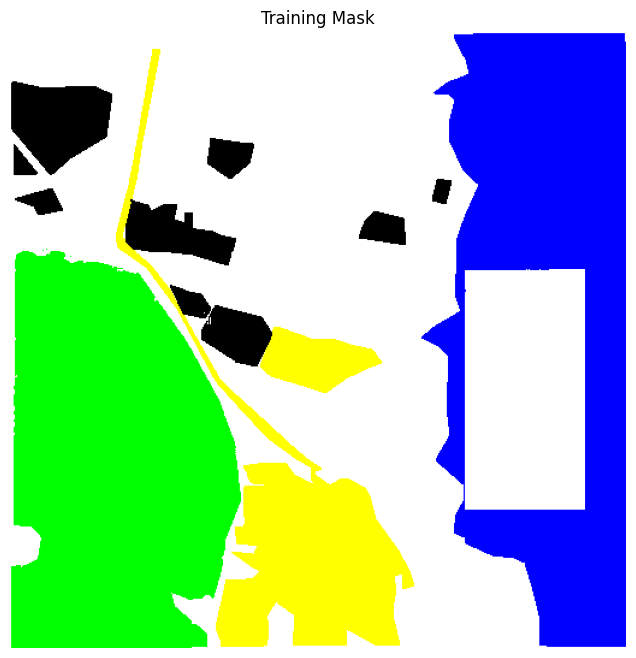

Accuracy: 96.53%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     47441
           1       1.00      0.99      0.99     50376
           2       0.87      0.82      0.84     12604
           3       0.90      0.93      0.91     23138

    accuracy                           0.97    133559
   macro avg       0.94      0.93      0.94    133559
weighted avg       0.97      0.97      0.97    133559



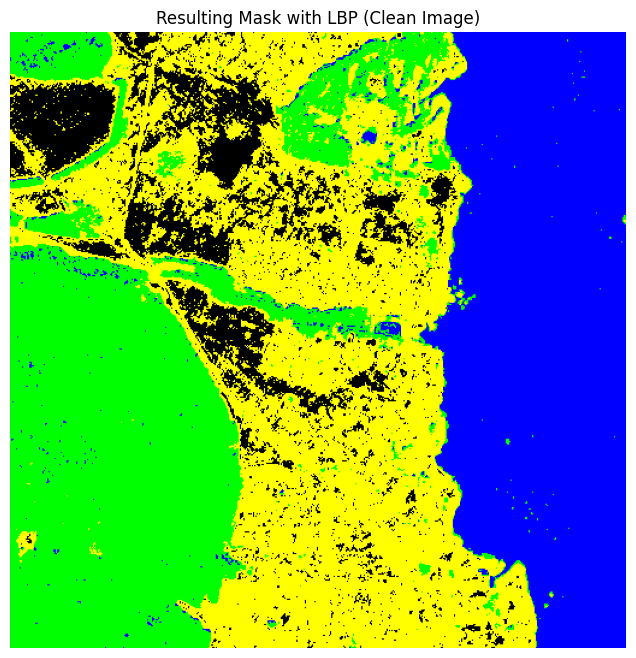

Noisy Image Validation Accuracy: 94.91%
Noisy Image Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     47922
           1       0.98      0.99      0.98     50888
           2       0.85      0.71      0.78     12738
           3       0.85      0.93      0.89     23360

    accuracy                           0.95    134908
   macro avg       0.92      0.90      0.91    134908
weighted avg       0.95      0.95      0.95    134908



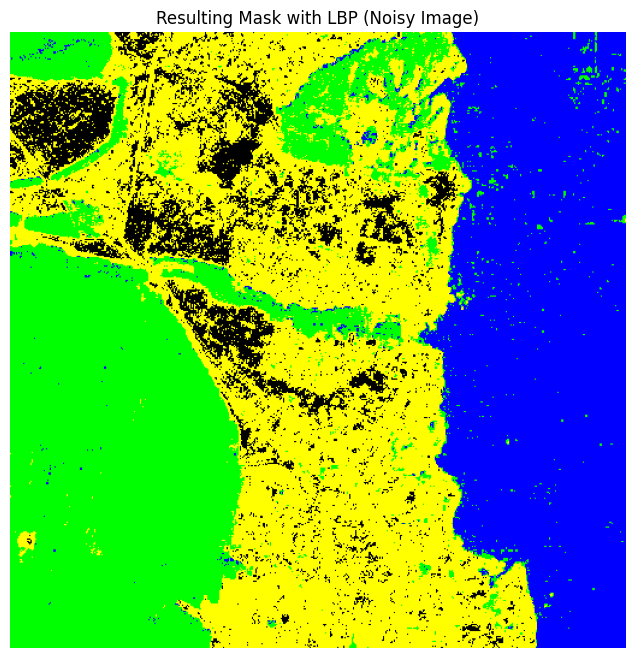

In [93]:
if __name__ == "__main__":
    # Paths to images
    image_path = "Images/sentinel/SS3/SS3.bmp"
    mask_path = "Images/sentinel/SS3/EtalonS3.bmp"
    noisy_image_path = "Images/sentinel/SS3/SS3_PSNR_33.2.bmp"  # Path to the pre-prepared noisy image

    # Read images and mask
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_COLOR)  # Load the noisy image
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    
    # Mapping colors to class indices
    color_to_class = {
        (0, 0, 255): 0,    # Blue - Water
        (0, 255, 0): 1,    # Green - Vegetation
        (0, 0, 0): 2,      # Black - Bare soil
        (255, 255, 0): 3   # Yellow - Urban
    }

    class_to_color = {v: k for k, v in color_to_class.items()}  # Reverse mapping for output

    # Data preparation (Train on clean data)
    sampled_coordinates, sampled_labels, training_mask = prepare_data_with_colored_mask(
        rgb_image, mask, color_to_class, pixel_sample_percentage=1.0
    )

    # Visualize selected training mask
    cv2.imwrite("Images/temp/training_mask.png", training_mask)  # Save training mask to file
    plt.figure(figsize=(8, 8))
    training_mask_rgb = cv2.cvtColor(training_mask, cv2.COLOR_BGR2RGB)
    plt.imshow(training_mask_rgb)
    plt.axis('off')
    plt.title("Training Mask")
    plt.show()

    # Feature extraction (from clean RGB image)
    features = extract_pixel_features_rgb_with_lbp_and_colors(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # Train model
    model = train_xgboost_classifier(features, sampled_labels)

    # Retrieve feature size from training data for classification
    expected_size = features.shape[1]  # Use the trained feature size

    # Classify entire clean image
    resulting_mask = classify_entire_image(
        rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=expected_size
    )
    
    # Save and display result for clean image
    resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)
    cv2.imwrite("Images/temp/result_colored_mask_lbp.png", resulting_mask_rgb)
    plt.figure(figsize=(8, 8))
    plt.imshow(resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with LBP (Clean Image)")
    plt.show()

    # === Validation on noisy image ===
    # Extract features from the noisy image
    noisy_features = extract_pixel_features_rgb_with_lbp_and_colors(
        noisy_image, sampled_coordinates, radius=2, n_points=16
    )

    # Predict on noisy features
    noisy_predictions = model.predict(noisy_features)

    # Evaluate noisy predictions
    noisy_accuracy = accuracy_score(sampled_labels, noisy_predictions)
    print(f"Noisy Image Validation Accuracy: {noisy_accuracy * 100:.2f}%")
    print("Noisy Image Validation Classification Report:")
    print(classification_report(sampled_labels, noisy_predictions))

    # Classify entire noisy image
    noisy_resulting_mask = classify_entire_image(
        noisy_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=expected_size
    )

    # Save and display result for noisy image
    noisy_resulting_mask_rgb = cv2.cvtColor(noisy_resulting_mask, cv2.COLOR_BGR2RGB)
    cv2.imwrite("Images/temp/noisy_result_colored_mask_lbp.png", noisy_resulting_mask_rgb)
    plt.figure(figsize=(8, 8))
    plt.imshow(noisy_resulting_mask)
    plt.axis('off')
    plt.title("Resulting Mask with LBP (Noisy Image)")
    plt.show()

---

## Скрипт: Загальний огляд

Скрипт складається з кількох модулів, які відповідають за різні етапи роботи класифікатора. Основний класифікатор працює на основі **LBP (Local Binary Patterns)** для текстурних ознак і кольорових ознак (RGB). На кожному пікселі (попіксельно) витягуються ознаки для навчання моделі **XGBoost**, яка потім використовується для класифікації кожного пікселя на новому зображенні.

---

### Основні функції в скрипті

1. **`prepare_data_with_colored_mask`**:
   Ця функція забезпечує підготовку даних для навчання класифікатора. Вона:
   - Вибирає координати пікселів із маски (`mask`), які позначені кольором.
   - Перетворює кольори маски у класи відповідно до заданого словника (`color_to_class`).
   - Вибірково бере частину пікселів (визначається параметром `pixel_sample_percentage`), що дозволяє навчати класифікатор на меншій і більш репрезентативній вибірці даних.

   **Конфігурування:**
   - **`pixel_sample_percentage`:**
     - Якщо класи сильно незбалансовані, збільшіть відсоток (наприклад, `0.7` або `1.0`), щоб захопити більше даних для рідкісних класів.
     - Зменшіть його для дуже великих масок і зображень, щоб уникнути високої обчислювальної складності.

   **Приклад виклику:**
   ```python
   sampled_coordinates, sampled_labels = prepare_data_with_colored_mask(
       rgb_image, mask, color_to_class, pixel_sample_percentage=0.5
   )
   ```

---

2. **`extract_pixel_features_rgb_with_lbp_and_colors`**:
   Ця функція витягує ознаки для кожного пікселя:
   - **LBP:** Текстурні ознаки, що відображають зміни яскравості в локальній області навколо пікселя (`radius`/`n_points`).
   - **RGB:** Кольорові значення пікселя (R, G, B).

   Усі ці компоненти об'єднуються в один вектор ознак, який використовується для навчання XGBoost.

   **Конфігурування:**
   - **`radius`:**
     - Радіус LBP визначає розмір локального контексту. Малий радіус (`1`–`2`) працює для текстур із дрібними деталями, великий радіус (`3`–`5`) — для більш широких текстур.
   - **`n_points`:**
     - Визначає кількість точок (пікселів) для LBP. Типово `n_points = 8 * radius`.
   - **`method`:**
     - Метод розрахунку LBP. Типово `"uniform"` для більш стабільних ознак.

   **Приклад виклику:**
   ```python
   features = extract_pixel_features_rgb_with_lbp_and_colors(
       rgb_image, sampled_coordinates, radius=2, n_points=16
   )
   ```

---

3. **`train_xgboost_classifier`**:
   Ця функція тренує модель XGBoost на основі витягнутих ознак (`features`) і класів пікселів (`labels`).

   **Конфігурування:**
   - **Hyperparameters in XGBoost (настроювані параметри):**
     - **`n_estimators` (кількість дерев):** Збільшіть до `200–300` для покращення точності моделі.
     - **`max_depth` (глибина дерев):** Баланс між деталізацією моделі та її схильністю до переобучення. Оптимально `4–8`.
     - **`eta` (learning_rate):** Зменште до `0.1` або `0.05` для більш плавного навчання моделі.

   **Приклад виклику:**
   ```python
   model = train_xgboost_classifier(features, sampled_labels)
   ```

---

4. **`classify_entire_image`**:
   Ця функція класифікує кожен піксель нового зображення, використовуючи натреновану модель XGBoost.

   - Витягує ознаки за допомогою LBP і RGB значень.
   - Передбачає клас кожного пікселя та генерує фінальну відобрачену маску у форматі RGB (або BGR).

   **Конфігурування:**
   - Параметри витягнення ознак (`radius`, `n_points`) повинні співпадати з навчальними.
   - Якщо виникають проблеми з розміром вектора ознак, використовуйте автоматичний підгін:
     ```python
     expected_size = features.shape[1]  # Отримане з навчальних даних
     feature_vector = np.pad(feature_vector, (0, expected_size - feature_vector.shape[0]), mode='constant')
     ```

   **Приклад виклику:**
   ```python
   resulting_mask = classify_entire_image(
       rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=expected_size
   )
   ```

---

### Загальна структура функцій

##### **Основний алгоритм**:
```python
if __name__ == "__main__":
    # 1. Завантажуємо зображення та маску.
    rgb_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)

    # 2. Готуємо координати та класи для навчання за маскою.
    sampled_coordinates, sampled_labels = prepare_data_with_colored_mask(
        rgb_image, mask, color_to_class, pixel_sample_percentage=0.5
    )

    # 3. Витягуємо ознаки LBP та кольору.
    features = extract_pixel_features_rgb_with_lbp_and_colors(
        rgb_image, sampled_coordinates, radius=2, n_points=16
    )

    # 4. Навчаємо модель XGBoost.
    model = train_xgboost_classifier(features, sampled_labels)

    # 5. Класифікуємо кожен піксель нового зображення.
    resulting_mask = classify_entire_image(
        rgb_image, model, radius=2, n_points=16, class_to_color=class_to_color, expected_size=features.shape[1]
    )

    # 6. Зберігаємо фінальну класифікаційну маску.
    resulting_mask_rgb = cv2.cvtColor(resulting_mask, cv2.COLOR_BGR2RGB)
    cv2.imwrite("Images/temp/result_colored_mask_lbp.png", resulting_mask_rgb)
    plt.imshow(resulting_mask_rgb)
    plt.show()
```

---

## Конфігурування класифікатора

1. **`pixel_sample_percentage` для навчання:**
   - Змінюйте цей параметр, щоб контролювати кількість прикладів для навчання.
   - При дисбалансі класів рекомендую збільшити до `0.6–0.8`.

2. **`radius` і `n_points` для LBP:**
   - **Малі значення (`radius=1`, `n_points=8`)** — для дрібних текстур.
   - **Великі значення (`radius=3–5`, `n_points=16–24`)** — для більш обширних текстур.

3. **Параметри XGBoost:**
   - **`learning_rate (eta)`**:
     - Зменште до `0.05` для досконалого навчання.
   - **`max_depth`**:
     - Зменшіть до `4–6`, якщо модель перевчена.

4. **Гіперпараметри через `GridSearchCV`**:
   Використовуйте:
   ```python
   from sklearn.model_selection import GridSearchCV

   param_grid = {
       'n_estimators': [100, 200, 300],
       'max_depth': [4, 6, 8],
       'learning_rate': [0.05, 0.1, 0.2]
   }

   grid_search = GridSearchCV(xgb.XGBClassifier(objective='multi:softmax', num_class=4), param_grid, cv=3)
   grid_search.fit(features, sampled_labels)

   print("Best parameters:", grid_search.best_params_)
   ```

5. **Підгін розмірів ознак (інференс):**
   Якщо отримуєте помилки через розмір вектора, програма автоматично коригує це за допомогою `np.pad`.

---

## Висновок

Класифікатор:
- Ефективний для аналізу текстур і кольорів на зображенні.
- Може бути легко сконфігурований для різних задач, залежно від розміру маски, кількості класів, та рівня текстур.

### Рекомендації:
1. Налаштуйте **`pixel_sample_percentage`**, щоб захопити достатньо даних.
2. Проведіть **гіперпараметричний пошук `GridSearchCV`** для оптимізації XGBoost.
3. Тестуйте різні **`radius` та `n_points`**, щоб знайти оптимальні налаштування для вашої текстури.

# Задача

